# Project: Identify Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

In [6]:
# importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline


'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, I will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, I will load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so I'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. I'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [8]:
azdias.shape

(891221, 85)

In [9]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [11]:
feat_info.shape

(85, 4)

In [12]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [13]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_REL,person,ordinal,[-1]
freq,1,43,49,26


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to help you make cleaning decisions during this stage of the project. First of all, I should assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I'll need to do a little bit of parsing to make use of it to identify and clean the data. I will convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [14]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [15]:
# Identifying missing or unknown data values and converting them to NaNs.
naturally_missing = azdias.isnull().sum().sum()
naturally_missing

4896838

In [16]:
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [17]:
for i in range(azdias.shape[1]):
    print(azdias[azdias.columns[i]].dtype)

int64
int64
int64
float64
int64
int64
int64
int64
int64
int64
int64
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
int64
int64
float64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
float64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
object
float64
object
object
object
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


In [18]:
%%time
for i in range(feat_info.shape[0]):
    cols=azdias.columns[i]
    var = feat_info['missing_or_unknown'][i]
    var_list = var.replace('[','').replace(']','').split(',')
    if var_list != ['']:
        for j in var_list:
            if azdias[cols].dtype =='object':
                azdias.loc[azdias[cols]==j,cols]=np.nan 
            else:
                j=int(j)
                azdias.loc[azdias[cols]==j,cols]=np.nan

CPU times: user 15.6 s, sys: 12.9 s, total: 28.6 s
Wall time: 18.3 s


In [19]:
coded_missing = azdias.isnull().sum().sum()
coded_missing

8373929

In [20]:
coded_missing - naturally_missing

3477091

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. I will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. I will identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project I should just remove them from the dataframe. 

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [21]:
# Performing an assessment of how much missing data there is in each column of the
# dataset.
missing_data_columns = (azdias.isnull().sum()/azdias.shape[0])*100
missing_data_columns

AGER_TYP                76.955435
ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
                          ...    
PLZ8_HHZ                13.073637
PLZ8_GBZ                13.073637
ARBEIT                  10.926022
ORTSGR_KLS9             10.914689
RELAT_AB                10.926022
Length: 85, dtype: float64

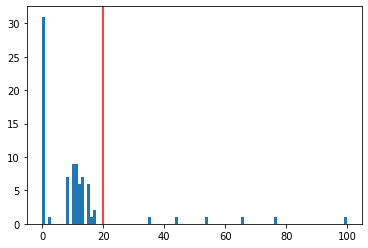

In [22]:
# Investigating patterns in the amount of missing data in each column.
plt.hist(missing_data_columns, bins = 101);
plt.axvline(x=20, color='red');

In [23]:
# Removing the outlier columns from the dataset.

outliers_columns = []
for i in range(azdias.shape[1]):
    if missing_data_columns[i] > 20:
        outliers_columns.append(azdias.columns[i])
print(outliers_columns)
azdias = azdias.drop(outliers_columns, axis=1)
azdias.shape[1]

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


79

#### Discussion 1.1.2: Assess Missing Data in Each Column

I removed all columns to the right of the red vertical line in the histogram of the ratio of missing data per column. The columns removed were missing more than 20% of data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? I will dividing the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. I will select at least five of these columns and compare the distribution of values.

If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. 

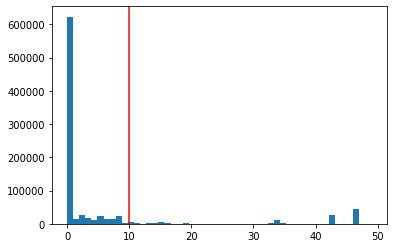

In [24]:
# How much data is missing in each row of the dataset?

missing_data_rows = azdias.isnull().sum(axis=1)
plt.hist(missing_data_rows, bins=50);
plt.axvline(x = 10, color = 'red');

In [25]:
missing_data_rows[:5]

0    43
1     0
2     0
3     7
4     0
dtype: int64

In [26]:
len(missing_data_rows) == azdias.shape[0]

True

In [27]:
azdias['missing_data_rows'] = missing_data_rows
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_data_rows
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [28]:
# Writing code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_1 = azdias[azdias['missing_data_rows'] < 10]
azdias_2 = azdias[azdias['missing_data_rows'] >= 10]

In [29]:
print(len(azdias_1))
print(len(azdias_2))
print(len(azdias_1)-len(azdias_2))

774743
116478
658265


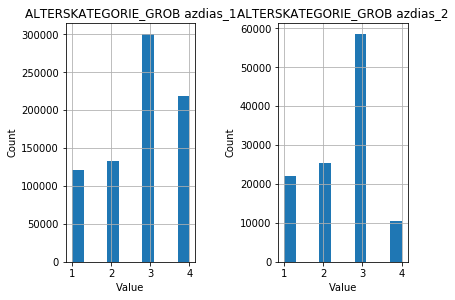

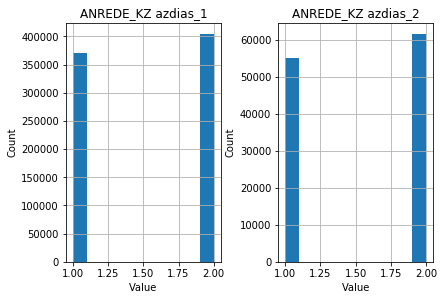

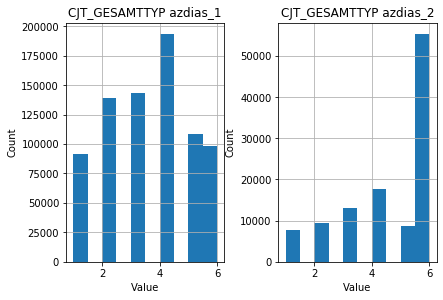

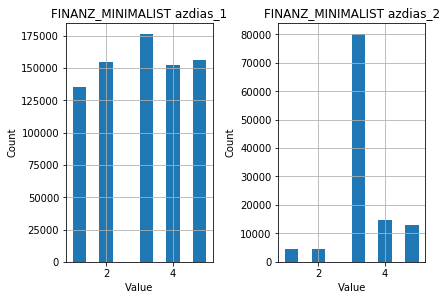

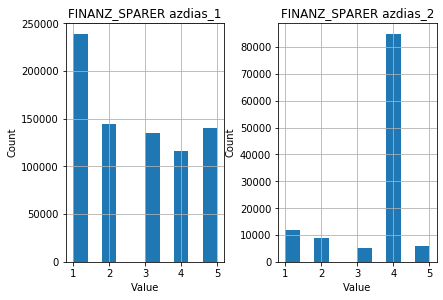

In [30]:
# Comparing the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare(num_col=5):
    col_name = azdias_1.columns[:num_col]
    for name in col_name:
        figure, axes = plt.subplots(nrows=1, ncols=2)
        azdias_1[name].hist(ax=axes[0])
        axes[0].set_title(name+' azdias_1')
        axes[0].set_xlabel('Value')
        axes[0].set_ylabel('Count')
        azdias_2[name].hist(ax=axes[1])
        axes[1].set_title(name+' azdias_2')
        axes[1].set_xlabel('Value')
        axes[1].set_ylabel('Count')
        figure.tight_layout(pad=0.1)
    
compare(5)

#### Discussion 1.1.3: Assess Missing Data in Each Row
 For 3 of the 5 plots we see the datasets agree on the most frequent value. For the dataset with lots of missing values we can see from the last two plots that one value is much more common than the others. The dataset with less variables gives us a better range of values and generally agrees with the conclusion of the the dataset with lots of missing values. For these reasons the analysis should contine with the dataset with few missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here.

In [31]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [32]:
# Assess categorical variables
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [33]:
cat_col = feat_info[feat_info['type'] == 'categorical'].attribute
binary_col = []
mixed_col = []
for name in cat_col:
    if name in azdias_1.columns:
        print(azdias_1[name].unique())
        if len(azdias_1[name].unique()) <= 3:
            binary_col.append(name)
        else:
            mixed_col.append(name)
    
print(binary_col)
print(mixed_col)

[2. 1.]
[5. 3. 2. 4. 1. 6.]
[1. 6. 5. 2. 4. 3.]
[10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6.]
[0 1]
[ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
[ 3.  1. nan  5.  2.  4.]
[ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7.]
[1. 2. 4. 5. 3.]
[ 1.  3.  2. nan]
[ 3.  2.  1.  0. nan]
[1. 0.]
[ 2.  1. nan]
[5. 3. 4. 1. 6. 2.]
[8. 1. 3. 2. 6. 4. 5.]
['W' 'O']
['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [34]:
# Re-encoding categorical variable(s) to be kept in the analysis.
azdias_1['OST_WEST_KZ'] = azdias_1['OST_WEST_KZ'].replace({'O': 0.0,'W': 1.0});
azdias_1['OST_WEST_KZ'].unique()

/Users/paulzebarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([1., 0.])

In [35]:
for name in mixed_col:
    azdias_1= pd.concat([azdias_1.drop(name, axis=1), 
                pd.get_dummies(data = azdias_1[name], columns = name, prefix = name)], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

I re-encoded the OST_WEST_KZ binary column for integer values 0 and 1. For the multi level columns I added dummy variables. I decided to keep the multilevel variables because we haven't used any machine learning yet and I'm not sure on their importance.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Be sure to check `Data_Dictionary.md` for the details.

In [36]:
# Investigating "PRAEGENDE_JUGENDJAHRE" and engineering two new variables.

azdias_1['PRAEGENDE_JUGENDJAHRE'].unique()

array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
       12., 13.,  7.])

In [37]:
azdias_1['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    177574
8.0     137903
10.0     83394
5.0      83112
3.0      52758
15.0     40803
11.0     34385
9.0      32939
6.0      25311
12.0     23925
4.0      20185
1.0      20106
2.0       7387
13.0      5520
7.0       3939
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [38]:
azdias_1['MAINTSTREAM'] = azdias_1['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]).astype(int)

In [39]:
# I couldve seperated it into one variable but would have used one hot encoding anyways
azdias_1['EAST'] = azdias_1['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]).astype(int)
azdias_1['WEST'] = azdias_1['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]).astype(int)
azdias_1['EAST + WEST'] = azdias_1['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]).astype(int)

In [40]:
# Investigating "CAMEO_INTL_2015" and engineering two new variables.
azdias_1['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [41]:
azdias_1['CAMEO_INTL_2015'].value_counts()

51    132086
41     90430
24     88559
14     60994
43     55429
54     44745
25     38587
22     31990
45     25610
13     25477
23     24111
55     23440
52     20258
34     18111
31     17721
15     16645
44     14502
12     12795
35     10139
32     10087
33      9571
Name: CAMEO_INTL_2015, dtype: int64

In [42]:
wealth_encoding = {'11': 1.0,'12': 1.0,'13': 1.0,'14': 1.0,'15': 1.0,'21': 2.0,'22': 2.0,'23': 2.0,
                   '24': 2.0,'25': 2.0,'31': 3.0,'32': 3.0,'33': 3.0,'34': 3.0,'35': 3.0,'41': 4.0,
                   '42': 4.0,'43': 4.0,'44': 4.0,'45': 4.0,'51': 5.0,'52': 5.0,'53': 5.0,'54': 5.0,
                   '55': 5.0}

In [43]:
azdias_1['WEALTH'] = azdias_1['CAMEO_INTL_2015'].replace(wealth_encoding)

In [44]:
azdias_1= pd.concat([azdias_1.drop('WEALTH', axis=1), 
                pd.get_dummies(data = azdias_1['WEALTH'], columns = 'WEALTH', prefix = 'WEALTH')], axis=1)

In [45]:
life_style_encoding = {'11': 1.0,'12': 2.0,'13': 3.0,'14': 4.0,'15': 5.0,'21': 1.0,'22': 2.0,'23': 3.0,
                       '24': 4.0,'25': 5.0,'31': 1.0,'32': 2.0,'33': 3.0,'34': 4.0, '35': 5.0,'41': 1.0,
                       '42': 2.0,'43': 3.0,'44': 4.0,'45': 5.0,'51': 1.0,'52': 2.0,'53': 3.0,'54': 4.0,
                       '55': 5.0}

In [46]:
azdias_1['LIFE_STYLE_TOPOLOGY'] = azdias_1['CAMEO_INTL_2015'].replace(life_style_encoding)

In [47]:
azdias_1= pd.concat([azdias_1.drop('LIFE_STYLE_TOPOLOGY', axis=1), 
                     pd.get_dummies(data = azdias_1['LIFE_STYLE_TOPOLOGY'], 
                                    columns = 'LIFE_STYLE_TOPOLOGY', prefix = 'LIFE_STYLE_TOPOLOGY')], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE had 15 unique values, I split them based on Data_Dictionary.md creating a new column for the variable 'MAINSTREAM' which describes the dominant movement of a person's life. It is encoded using a 1 or 0 for mainstream or avantgarde respectively. CAMEO_INTL_2015 had 15 unique values, I split them based on Data_Dictionary.md creating a new column for the variable 'WEALTH' which encodes how wealthy the person is and used dummy variables for each level. I also created 'LIFE_STYLE_TOPOLOGY' from CAMEO_INTL_2015 I split them based on Data_Dictionary.md creating a new column which describes the type of family, I used dummy variables for each level.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, I need to make sure that my data frame now only has the columns that I want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

I need to make sure that for any new columns that I have engineered, that I've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, I should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features I created should be retained. 

In [48]:
missing_data_rows = azdias.isnull().sum(axis=1)
azdias['missing_data_rows'] = missing_data_rows
azdias = azdias[azdias['missing_data_rows'] < 10]

cat_col = feat_info[feat_info['type'] == 'categorical'].attribute
binary_col = []
mixed_col = []
for name in cat_col:
    if name in azdias.columns:
        if len(azdias[name].unique()) <= 3:
            binary_col.append(name)
        else:
            mixed_col.append(name)

azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'O': 0.0,'W': 1.0});
azdias['OST_WEST_KZ'].unique()

azdias['MAINTSTREAM'] = azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]).astype(int)

azdias['EAST'] = azdias['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]).astype(int)
azdias['WEST'] = azdias['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]).astype(int)
azdias['EAST + WEST'] = azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]).astype(int)

wealth_encoding = {'11': 1.0,'12': 1.0,'13': 1.0,'14': 1.0,'15': 1.0,'21': 2.0,'22': 2.0,'23': 2.0,
                   '24': 2.0,'25': 2.0,'31': 3.0,'32': 3.0,'33': 3.0,'34': 3.0,'35': 3.0,'41': 4.0,
                   '42': 4.0,'43': 4.0,'44': 4.0,'45': 4.0,'51': 5.0,'52': 5.0,'53': 5.0,'54': 5.0,
                   '55': 5.0}

azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].replace(wealth_encoding)

life_style_encoding = {'11': 1.0,'12': 2.0,'13': 3.0,'14': 4.0,'15': 5.0,'21': 1.0,'22': 2.0,'23': 3.0,
                       '24': 4.0,'25': 5.0,'31': 1.0,'32': 2.0,'33': 3.0,'34': 4.0, '35': 5.0,'41': 1.0,
                       '42': 2.0,'43': 3.0,'44': 4.0,'45': 5.0,'51': 1.0,'52': 2.0,'53': 3.0,'54': 4.0,
                       '55': 5.0}

azdias['LIFE_STYLE_TOPOLOGY'] = azdias['CAMEO_INTL_2015'].replace(life_style_encoding)


In [49]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

for name in mixed_col:
    azdias = pd.concat([azdias.drop(name, axis=1), 
                pd.get_dummies(data = azdias[name], columns = name, prefix = name)], axis=1)

azdias = pd.concat([azdias.drop('WEALTH', axis=1), 
                pd.get_dummies(data = azdias['WEALTH'], columns = 'WEALTH', prefix = 'WEALTH')], axis=1)

azdias = pd.concat([azdias.drop('LIFE_STYLE_TOPOLOGY', axis=1), 
                     pd.get_dummies(data = azdias['LIFE_STYLE_TOPOLOGY'], 
                                    columns = 'LIFE_STYLE_TOPOLOGY', prefix = 'LIFE_STYLE_TOPOLOGY')], axis=1)

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, I will complete the function below to execute the main feature selection, encoding, and re-engineering steps I performed above. Then, when it comes to looking at the customer data in Step 3, I can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [213]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    
    # Convert missing value codes into NaNs, ...
    
    for i in range(feat_info.shape[0]):
        cols = df.columns[i]
        var = feat_info['missing_or_unknown'][i]
        var_list = var.replace('[','').replace(']','').split(',')
        if var_list != ['']:
            for j in var_list:
                if df[cols].dtype =='object':
                    df.loc[df[cols]==j,cols]=np.nan 
                else:
                    j=int(j)
                    df.loc[df[cols]==j,cols]=np.nan

    # remove selected columns and rows, ...
    
    missing_data_columns = (df.isnull().sum()/df.shape[0])*100

    outliers_columns = []
    for i in range(df.shape[1]):
        if missing_data_columns[i] > 20:
            outliers_columns.append(df.columns[i])
            
    df = df.drop(outliers_columns, axis=1)
            
    missing_data_rows = df.isnull().sum(axis=1)
    df['missing_data_rows'] = missing_data_rows
    df = df[df['missing_data_rows'] < 10]
    
    # select, re-encode, and engineer column values.
    
    cat_col = feat_info[feat_info['type'] == 'categorical'].attribute
    binary_col = []
    mixed_col = []
    for name in cat_col:
        if name in df.columns:
            if len(df[name].unique()) <= 3:
                binary_col.append(name)
            else:
                mixed_col.append(name)
                
    for name in mixed_col:
        df = pd.concat([df.drop(name, axis=1), 
                    pd.get_dummies(data = df[name], columns = name, prefix = name)], axis=1)

    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0.0,'W': 1.0});
    df['OST_WEST_KZ'].unique()

    df['MAINTSTREAM'] = df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]).astype(int)

    df['EAST'] = df['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]).astype(int)
    df['WEST'] = df['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]).astype(int)
    df['EAST + WEST'] = df['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]).astype(int)

    wealth_encoding = {'11': 1.0,'12': 1.0,'13': 1.0,'14': 1.0,'15': 1.0,'21': 2.0,'22': 2.0,'23': 2.0,
                       '24': 2.0,'25': 2.0,'31': 3.0,'32': 3.0,'33': 3.0,'34': 3.0,'35': 3.0,'41': 4.0,
                       '42': 4.0,'43': 4.0,'44': 4.0,'45': 4.0,'51': 5.0,'52': 5.0,'53': 5.0,'54': 5.0,
                       '55': 5.0}

    df['WEALTH'] = df['CAMEO_INTL_2015'].replace(wealth_encoding)
    
    df = pd.concat([df.drop('WEALTH', axis=1), 
                pd.get_dummies(data = df['WEALTH'], columns = 'WEALTH', prefix = 'WEALTH')], axis=1)


    life_style_encoding = {'11': 1.0,'12': 2.0,'13': 3.0,'14': 4.0,'15': 5.0,'21': 1.0,'22': 2.0,'23': 3.0,
                           '24': 4.0,'25': 5.0,'31': 1.0,'32': 2.0,'33': 3.0,'34': 4.0, '35': 5.0,'41': 1.0,
                           '42': 2.0,'43': 3.0,'44': 4.0,'45': 5.0,'51': 1.0,'52': 2.0,'53': 3.0,'54': 4.0,
                           '55': 5.0}

    df['LIFE_STYLE_TOPOLOGY'] = df['CAMEO_INTL_2015'].replace(life_style_encoding)
    
    
    df = pd.concat([df.drop('LIFE_STYLE_TOPOLOGY', axis=1), 
                     pd.get_dummies(data = df['LIFE_STYLE_TOPOLOGY'], 
                                    columns = 'LIFE_STYLE_TOPOLOGY', prefix = 'LIFE_STYLE_TOPOLOGY')], axis=1)
    
    # Return the cleaned dataframe.
    
    return df
    
azdias = clean_data(azdias);  

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before I apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that we'll need. In this substep, I'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to our data, we need to make sure that we've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. we could also try a more complicated procedure where we temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data we have and what possible effects each approach might have on our analysis.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, we can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time.

In [214]:
columns = azdias.columns

In [106]:
azdias.isnull().sum(axis=0)

ALTERSKATEGORIE_GROB       2596
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
                           ... 
LIFE_STYLE_TOPOLOGY_1.0       0
LIFE_STYLE_TOPOLOGY_2.0       0
LIFE_STYLE_TOPOLOGY_3.0       0
LIFE_STYLE_TOPOLOGY_4.0       0
LIFE_STYLE_TOPOLOGY_5.0       0
Length: 209, dtype: int64

In [215]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan , strategy='most_frequent')
azdias = imp.fit_transform(azdias)

In [216]:
# Applying feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias = scaler.fit_transform(azdias)

In [217]:
azdias = pd.DataFrame(azdias)
azdias.columns = columns
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WEALTH_1.0,WEALTH_2.0,WEALTH_3.0,WEALTH_4.0,WEALTH_5.0,LIFE_STYLE_TOPOLOGY_1.0,LIFE_STYLE_TOPOLOGY_2.0,LIFE_STYLE_TOPOLOGY_3.0,LIFE_STYLE_TOPOLOGY_4.0,LIFE_STYLE_TOPOLOGY_5.0
0,-1.765558,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.007436,...,-0.419445,-0.556599,-0.304221,-0.562016,1.585280,1.491614,-0.327701,-0.416626,-0.643582,-0.41627
1,0.198811,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.007436,...,-0.419445,1.796625,-0.304221,-0.562016,-0.630804,-0.670415,-0.327701,-0.416626,1.553803,-0.41627
2,1.180995,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.315096,...,2.384103,-0.556599,-0.304221,-0.562016,-0.630804,-0.670415,3.051562,-0.416626,-0.643582,-0.41627
3,0.198811,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.007436,...,-0.419445,-0.556599,-0.304221,1.779307,-0.630804,-0.670415,-0.327701,2.400233,-0.643582,-0.41627
4,-1.765558,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.007436,...,-0.419445,-0.556599,-0.304221,-0.562016,1.585280,-0.670415,-0.327701,-0.416626,1.553803,-0.41627


In [110]:
azdias.isnull().sum().sum()

0

### Discussion 2.1: Apply Feature Scaling

I imputed the missing values using  the most frequent count because not all variables were floats or integers which prevented them from being filled using mean or median.

### Step 2.2: Perform Dimensionality Reduction

On our scaled data, we are now ready to apply dimensionality reduction techniques.

- I will use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- I will check out the ratio of variance explained by each principal component as well as the cumulative variance explained. I will try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what I find, I can select a value for the number of transformed features I'll retain for the clustering part of the project.
- Once I've made a choice for the number of components to keep, I will make sure we re-fit a PCA instance to perform the decided-on transformation.

In [60]:
# Applying PCA to the data.

from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(azdias)

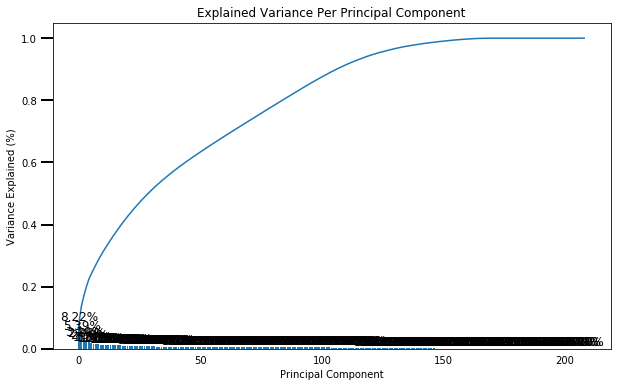

In [61]:
# Investigating the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)


In [218]:
# Re-applying PCA to the data while selecting for number of components to retain.

pca = PCA(120)
azdias_pca = pca.fit_transform(azdias)

### Discussion 2.2: Perform Dimensionality Reduction

I choose to keep 120 components to acheive a variance of approximately 90% for the next step in my analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Using the data dictionary document to help I can understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- We should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, I should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters.

In [63]:
# Mapping weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def pca_components(component):
    
    pca_components = pd.DataFrame(pca.components_[component])
    pca_components.index = azdias.columns
    pca_components.columns = ['PC']
    pca_components = pca_components.sort_values(by=['PC'], axis=0, ascending=False)
    
    return pca_components

pca_components(0)

,PC
LP_STATUS_GROB_1.0,0.183086
CAMEO_INTL_2015,0.179278
PLZ8_ANTG3,0.176090
HH_EINKOMMEN_SCORE,0.175829
PLZ8_ANTG4,0.169480
...,...
FINANZ_MINIMALIST,-0.170333
KBA05_GBZ,-0.171957
KBA05_ANTG1,-0.173895
PLZ8_ANTG1,-0.177247


In [64]:
# Mapping weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_components(1)

,PC
ALTERSKATEGORIE_GROB,0.238786
FINANZ_VORSORGER,0.224735
ZABEOTYP_3.0,0.198780
SEMIO_ERL,0.181601
SEMIO_LUST,0.165400
...,...
SEMIO_PFLICHT,-0.213736
FINANZ_UNAUFFAELLIGER,-0.218004
SEMIO_REL,-0.220903
FINANZ_SPARER,-0.236797


In [65]:
# Mapping weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_components(2)

,PC
SEMIO_VERT,0.309278
SEMIO_SOZ,0.250336
SEMIO_FAM,0.248674
SEMIO_KULT,0.239871
FINANZTYP_5.0,0.138672
...,...
SEMIO_ERL,-0.199961
SEMIO_KRIT,-0.259646
SEMIO_DOM,-0.264396
SEMIO_KAEM,-0.298072


### Discussion 2.3: Interpret Principal Components

The top 5 positive and negative weights for each component are:

>PC 1(Positive Weights): LP_STATUS_GROB_1.0, CAMEO_INTL_2015, PLZ8_ANTG3, HH_EINKOMMEN_SCORE, PLZ8_ANTG4

>PC 1(Negative Weights): MOBI_REGIO, PLZ8_ANTG1, KBA05_ANTG1, KBA05_GBZ, FINANZ_MINIMALIST	

>PC 2(Positive Weights): ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3.0, SEMIO_ERL, SEMIO_LUST

>PC 2(Negative Weights): PRAEGENDE_JUGENDJAHRE, FINANZ_SPARER, SEMIO_REL, FINANZ_UNAUFFAELLIGER, SEMIO_PFLICHT

>PC 3(Positive Weights): SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT, FINANZTYP_5.0

>PC 3(Negative Weights): ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_ERL

Using DataDictionary.md we can conclude that the components must be related by:

>PC 1: The positive features are about wealth, family size and family size in the nieghbourhood. The negative features are about movement, family size and number of buildings. We can conclude this component is about wealth, family size, and the type of buildings in the neighbourhood.

>PC 2: The positive features are about age, whether youre a saver, and energy consumption. The negative features are also about whether youre a saver and other features about your personanilty. We can conclude this component is about age.

>PC 3: The postive features are about personality types. the negative features are also about personality types. we can conlude this component is about personality.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Using sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, I compute the average difference from each point to its assigned cluster's center. The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. 
- Performing the above two steps for a number of different cluster counts, we can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Using this fact we can select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. 
- Once we've selected a final number of clusters to use, I will re-fit a KMeans instance to perform the clustering operation.

In [74]:
# Over a number of different cluster counts...
# running k-means clustering on the data and...

from sklearn.cluster import KMeans

def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(1,11))

# computing the average within-cluster distances.

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))

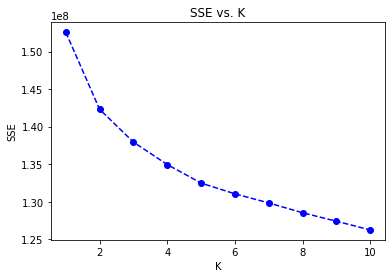

In [75]:
# Investigating the change in within-cluster distance across number of clusters.
   
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [219]:
# Re-fitting the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 5)
model = kmeans.fit(azdias_pca)
azdias_labels = model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

I choose to use 5 clusters for KMeans. After observing the scree plot we can identify two elbows at 2 and 5. I opted for 5 clusters because it had a lower score.

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, I'm going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, I will interpret how the general population fits apply to the customer data.

- Using the sklearn objects from the general demographics data, and applying their transformations to the customers data. That is, we should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should we be creating new sklearn objects! We should carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [159]:
# Loading in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [161]:
# Applying preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

for i in range(feat_info.shape[0]):
    cols = customers.columns[i]
    var = feat_info['missing_or_unknown'][i]
    var_list = var.replace('[','').replace(']','').split(',')
    if var_list != ['']:
        for j in var_list:
            if customers[cols].dtype =='object':
                customers.loc[customers[cols]==j,cols]=np.nan 
            else:
                j=int(j)
                customers.loc[customers[cols]==j,cols]=np.nan

outliers_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

customers = customers.drop(outliers_columns, axis=1)

missing_data_rows = customers.isnull().sum(axis=1)
customers['missing_data_rows'] = missing_data_rows
customers = customers[customers['missing_data_rows'] < 10]

cat_col = feat_info[feat_info['type'] == 'categorical'].attribute
binary_col = []
mixed_col = []
for name in cat_col:
    if name in customers.columns:
        if len(customers[name].unique()) <= 3:
            binary_col.append(name)
        else:
            mixed_col.append(name)

for name in mixed_col:
    customers = pd.concat([customers.drop(name, axis=1), 
                pd.get_dummies(data = customers[name], columns = name, prefix = name)], axis=1)

customers['OST_WEST_KZ'] = customers['OST_WEST_KZ'].replace({'O': 0.0,'W': 1.0});

customers['MAINTSTREAM'] = customers['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]).astype(int)

customers['EAST'] = customers['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]).astype(int)
customers['WEST'] = customers['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]).astype(int)
customers['EAST + WEST'] = customers['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]).astype(int)

wealth_encoding = {'11': 1.0,'12': 1.0,'13': 1.0,'14': 1.0,'15': 1.0,'21': 2.0,'22': 2.0,'23': 2.0,
                   '24': 2.0,'25': 2.0,'31': 3.0,'32': 3.0,'33': 3.0,'34': 3.0,'35': 3.0,'41': 4.0,
                   '42': 4.0,'43': 4.0,'44': 4.0,'45': 4.0,'51': 5.0,'52': 5.0,'53': 5.0,'54': 5.0,
                   '55': 5.0}

customers['WEALTH'] = customers['CAMEO_INTL_2015'].replace(wealth_encoding)

customers = pd.concat([customers.drop('WEALTH', axis=1), 
            pd.get_dummies(data = customers['WEALTH'], columns = 'WEALTH', prefix = 'WEALTH')], axis=1)


life_style_encoding = {'11': 1.0,'12': 2.0,'13': 3.0,'14': 4.0,'15': 5.0,'21': 1.0,'22': 2.0,'23': 3.0,
                       '24': 4.0,'25': 5.0,'31': 1.0,'32': 2.0,'33': 3.0,'34': 4.0, '35': 5.0,'41': 1.0,
                       '42': 2.0,'43': 3.0,'44': 4.0,'45': 5.0,'51': 1.0,'52': 2.0,'53': 3.0,'54': 4.0,
                       '55': 5.0}

customers['LIFE_STYLE_TOPOLOGY'] = customers['CAMEO_INTL_2015'].replace(life_style_encoding)


customers = pd.concat([customers.drop('LIFE_STYLE_TOPOLOGY', axis=1), 
                 pd.get_dummies(data = customers['LIFE_STYLE_TOPOLOGY'], 
                                columns = 'LIFE_STYLE_TOPOLOGY', prefix = 'LIFE_STYLE_TOPOLOGY')], axis=1)

In [165]:
for i in range(208):
    if azdias.columns[i] != customers.columns[i]:
        print(azdias.columns[i])
        print(customers.columns[i])
        break

GEBAEUDETYP_5.0
GEBAEUDETYP_6.0


In [176]:
customers['GEBAEUDETYP_5.0'] = 0

In [177]:
len(azdias.columns)

209

In [178]:
len(customers.columns)

209

In [182]:
imp = SimpleImputer(missing_values = np.nan , strategy='most_frequent')
customers = imp.fit_transform(customers)

scaler = StandardScaler()
customers = scaler.fit_transform(customers)

customers = pd.DataFrame(customers)
customers.columns = columns

pca = PCA(120)
customers_pca = pca.fit_transform(customers)
customers_labels = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- I will compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis we performed in step 1.1.3 of the project, where I separated out certain data points from the dataset if they had more than a specified threshold of missing values. If we found that this group was qualitatively different from the main bulk of the data, we should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? We can select at least one such cluster and infer what kind of people might be represented by that cluster. Using the principal component interpretations from step 2.3 or looking at additional components to help me make this inference. Alternatively, I can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Performing a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

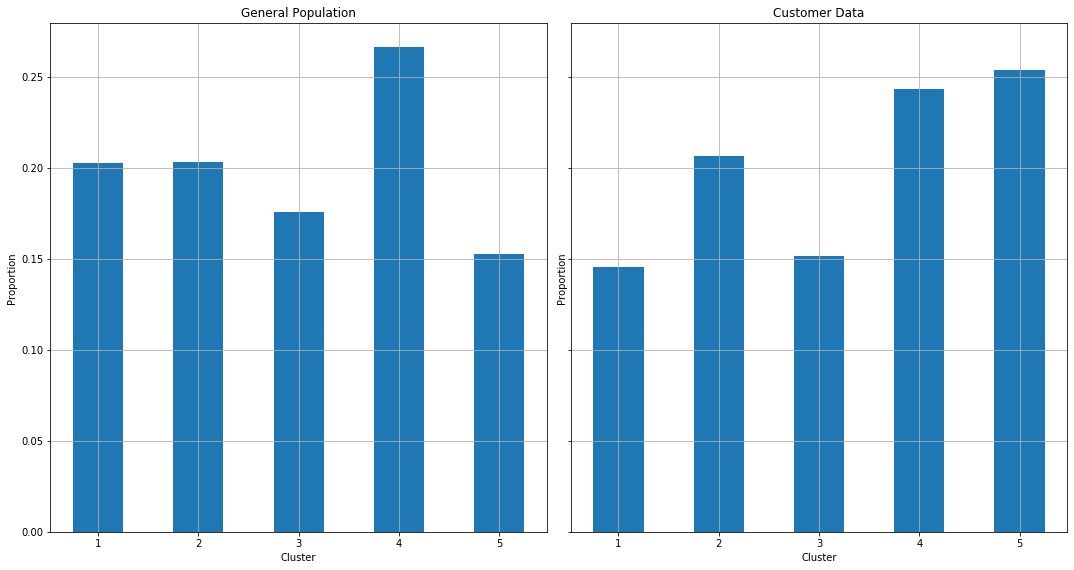

In [222]:
# Comparing the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

azdias_labels = pd.DataFrame(azdias_labels)
azdias_labels.columns = ['clusters']
customers_labels = pd.DataFrame(customers_labels)
customers_labels.columns = ['clusters']

figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8), sharey=True)
azdias_labels['clusters'].hist(ax=axes[0], 
                               weights=np.ones(len(azdias_labels['clusters'])) / len(azdias_labels['clusters']),
                               align='right',
                               bins = range(0,6),
                               rwidth=0.5)
axes[0].set_title('General Population')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Proportion')
customers_labels['clusters'].hist(ax=axes[1],
                                  weights=np.ones(len(customers_labels['clusters'])) / len(customers_labels['clusters']),
                                  align='right',
                                  bins = range(0,6),
                                  rwidth=0.5)
axes[1].set_title('Customer Data')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Proportion')
figure.tight_layout(pad=1)

In [223]:
azdias_labels.index = azdias.index
azdias = pd.concat([azdias,azdias_labels],axis=1)

In [272]:
original_data = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
original_data = clean_data(original_data)
columns_original_data = original_data.columns
imp_test = SimpleImputer(missing_values = np.nan , strategy='most_frequent')
original_data = imp_test.fit_transform(original_data)
original_data = pd.DataFrame(original_data)
original_data.columns = columns_original_data
results = pd.concat([original_data, azdias['clusters']], axis = 1)

In [273]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_overrepresented = results[results['clusters'] == 4]

for i in range(cluster_overrepresented.shape[1]):
    print(cluster_overrepresented[cluster_overrepresented.columns[i]].value_counts())

3.0    54808
4.0    47134
2.0    10995
1.0     5098
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    61780
2.0    56255
Name: ANREDE_KZ, dtype: int64
5.0    71632
4.0    36476
3.0     8425
2.0     1316
1.0      186
Name: FINANZ_MINIMALIST, dtype: int64
1.0    55563
2.0    37927
3.0    16068
4.0     6968
5.0     1509
Name: FINANZ_SPARER, dtype: int64
5.0    52076
4.0    38164
3.0    13185
1.0     7376
2.0     7234
Name: FINANZ_VORSORGER, dtype: int64
1.0    56939
2.0    27105
3.0    18930
4.0    12044
5.0     3017
Name: FINANZ_ANLEGER, dtype: int64
2.0    40950
1.0    33735
3.0    26880
5.0     8986
4.0     7484
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
1.0    46534
2.0    38847
3.0    21146
4.0     9089
5.0     2419
Name: FINANZ_HAUSBAUER, dtype: int64
1    112302
0      5733
Name: GREEN_AVANTGARDE, dtype: int64
2.0    44563
3.0    43771
1.0    29701
Name: HEALTH_TYP, dtype: int64
13.0    22444
20.0    15702
39.0    14909
40.0    13935
35.0    10840
28.0     9923
10.0     5028
36.0     

3.0    39199
4.0    38572
5.0    36520
2.0     3453
1.0      291
Name: PLZ8_GBZ, dtype: int64
3.0    41761
4.0    37329
2.0    26563
1.0     9894
5.0     2488
Name: ARBEIT, dtype: int64
5.0    29141
4.0    24348
6.0    15028
7.0    14536
3.0     9635
8.0     8191
9.0     7942
2.0     6779
1.0     2435
Name: ORTSGR_KLS9, dtype: int64
3.0    37963
1.0    27200
5.0    21830
2.0    18931
4.0    12111
Name: RELAT_AB, dtype: int64
0    102279
2      4368
6      2190
5      1942
3      1906
8      1677
4      1373
7      1282
1       848
9       170
Name: missing_data_rows, dtype: int64
0    103281
1     14754
Name: CJT_GESAMTTYP_1.0, dtype: int64
0    90845
1    27190
Name: CJT_GESAMTTYP_2.0, dtype: int64
0    97023
1    21012
Name: CJT_GESAMTTYP_3.0, dtype: int64
0    93685
1    24350
Name: CJT_GESAMTTYP_4.0, dtype: int64
0    103191
1     14844
Name: CJT_GESAMTTYP_5.0, dtype: int64
0    102150
1     15885
Name: CJT_GESAMTTYP_6.0, dtype: int64
0    116718
1      1317
Name: FINANZTYP_1.0, dt

0    105805
1     12230
Name: LIFE_STYLE_TOPOLOGY_2.0, dtype: int64
0    97505
1    20530
Name: LIFE_STYLE_TOPOLOGY_3.0, dtype: int64
0    64464
1    53571
Name: LIFE_STYLE_TOPOLOGY_4.0, dtype: int64
0    94287
1    23748
Name: LIFE_STYLE_TOPOLOGY_5.0, dtype: int64
4    118035
Name: clusters, dtype: int64


In [275]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_underrepresented = results[results['clusters'] == 0]

for i in range(cluster_underrepresented.shape[1]):
    print(cluster_underrepresented[cluster_underrepresented.columns[i]].value_counts())

3.0    77444
4.0    72522
2.0     4459
1.0     2659
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    79571
2.0    77513
Name: ANREDE_KZ, dtype: int64
5.0    73763
4.0    53989
3.0    22425
2.0     6734
1.0      173
Name: FINANZ_MINIMALIST, dtype: int64
1.0    80275
2.0    50431
3.0    22815
4.0     3096
5.0      467
Name: FINANZ_SPARER, dtype: int64
5.0    73625
4.0    58552
3.0    21109
1.0     2175
2.0     1623
Name: FINANZ_VORSORGER, dtype: int64
2.0    45919
1.0    42644
3.0    32827
4.0    27705
5.0     7989
Name: FINANZ_ANLEGER, dtype: int64
1.0    68254
2.0    55357
3.0    28948
4.0     2888
5.0     1637
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    46012
1.0    44541
3.0    31300
4.0    21645
5.0    13586
Name: FINANZ_HAUSBAUER, dtype: int64
0    152445
1      4639
Name: GREEN_AVANTGARDE, dtype: int64
3.0    64723
2.0    59049
1.0    33312
Name: HEALTH_TYP, dtype: int64
11.0    20936
12.0    19820
19.0    17117
37.0    15954
38.0    12519
8.0      9714
7.0      8712
32.0     

3.0    35449
2.0    31346
4.0    28798
5.0    26096
1.0    23096
6.0     5672
7.0     3947
8.0     1687
9.0      993
Name: ORTSGR_KLS9, dtype: int64
1.0    54040
3.0    43279
2.0    31395
5.0    16319
4.0    12051
Name: RELAT_AB, dtype: int64
0    120096
2     10475
3      6287
8      4846
5      3619
6      3564
7      2854
1      2503
4      1752
9      1088
Name: missing_data_rows, dtype: int64
0    133150
1     23934
Name: CJT_GESAMTTYP_1.0, dtype: int64
0    105037
1     52047
Name: CJT_GESAMTTYP_2.0, dtype: int64
0    132102
1     24982
Name: CJT_GESAMTTYP_3.0, dtype: int64
0    126929
1     30155
Name: CJT_GESAMTTYP_4.0, dtype: int64
0    139148
1     17936
Name: CJT_GESAMTTYP_5.0, dtype: int64
0    149054
1      8030
Name: CJT_GESAMTTYP_6.0, dtype: int64
0    154500
1      2584
Name: FINANZTYP_1.0, dtype: int64
0    110392
1     46692
Name: FINANZTYP_2.0, dtype: int64
0    151402
1      5682
Name: FINANZTYP_3.0, dtype: int64
0    156344
1       740
Name: FINANZTYP_4.0, dtype: i

Name: WEST, dtype: int64
1    130571
0     26513
Name: EAST + WEST, dtype: int64
0    127768
1     29316
Name: WEALTH_1.0, dtype: int64
0    84254
1    72830
Name: WEALTH_2.0, dtype: int64
0    142217
1     14867
Name: WEALTH_3.0, dtype: int64
0    125414
1     31670
Name: WEALTH_4.0, dtype: int64
0    149897
1      7187
Name: WEALTH_5.0, dtype: int64
0    140066
1     17018
Name: LIFE_STYLE_TOPOLOGY_1.0, dtype: int64
0    134608
1     22476
Name: LIFE_STYLE_TOPOLOGY_2.0, dtype: int64
0    120902
1     36182
Name: LIFE_STYLE_TOPOLOGY_3.0, dtype: int64
0    101291
1     55793
Name: LIFE_STYLE_TOPOLOGY_4.0, dtype: int64
0    132683
1     24401
Name: LIFE_STYLE_TOPOLOGY_5.0, dtype: int64
0    157084
Name: clusters, dtype: int64


### Discussion 3.3: Compare Customer Data to Demographics Data

The underrepresented data shows the target audience for the company. From cluster 5 we can learn about the demographic. The target audience is mainly male (ANREDE_KZ: 1.0), with a high income (FINANZ_: 1.0-2.0), who are single or are a couple (LP_LEBENSPHASE_FEIN: 20.0, 13.0).

The overrepresented data shows audience which does not appeal to the company. From cluster 1 we can learn about the demographic. The unpopular audience is mainly male/female (ANREDE_KZ: 1.0, 2.0), with a lower income (FINANZ_: 5.0-2.0), who are of retirement or late age (LP_LEBENSPHASE_FEIN: 11.0, 12.0).

